**SETUP**

In [ ]:
!pip install transformers

In [ ]:
!ls

adc.json  gdrive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import re
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Training the model

In [ ]:
!ls

Datasets       Misc	  Real_time_twitter_data
kafka-project  model.png  Trained_models


In [ ]:
df= pd.read_csv('Datasets/tweet_dataset.csv')
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


We select the useful coloumns from the dataset and make a new dataframe for training purpose.

In [ ]:
train= pd.DataFrame()
train['text']= df['text']
train['Sentiment']=df['new_sentiment']

In [ ]:
train=train.dropna()

In [ ]:
train['Sentiment'] = train['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])

**Importing the BERT Tokenizer**

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


**Pre Processing**

In [ ]:
max_len = 0
for tweet in train['text']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))        #maximum length of input ids

print('Max sequence length: ', max_len)

Max sequence length:  110


In [ ]:

input_ids = []
attention_masks = []

for sent in train['text']:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Datasets and Dataloaders**

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)  #storing the input ids,masks and labels in dataset

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  #90-10 train-val split

# creating dataloaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),     
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),    
            batch_size = batch_size 
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Optimizer**

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def pred_accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred == labels_flat) / len(labels_flat)

# Time lapsed

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Training**


In [ ]:
import random
import numpy as np


seed_val = 42
epochs=5

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.to(device)


training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        
        # Printing the progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += pred_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    882.    Elapsed: 0:00:23.
  Batch    80  of    882.    Elapsed: 0:00:46.
  Batch   120  of    882.    Elapsed: 0:01:09.
  Batch   160  of    882.    Elapsed: 0:01:33.
  Batch   200  of    882.    Elapsed: 0:01:57.
  Batch   240  of    882.    Elapsed: 0:02:21.
  Batch   280  of    882.    Elapsed: 0:02:45.
  Batch   320  of    882.    Elapsed: 0:03:09.
  Batch   360  of    882.    Elapsed: 0:03:33.
  Batch   400  of    882.    Elapsed: 0:03:57.
  Batch   440  of    882.    Elapsed: 0:04:21.
  Batch   480  of    882.    Elapsed: 0:04:45.
  Batch   520  of    882.    Elapsed: 0:05:09.
  Batch   560  of    882.    Elapsed: 0:05:32.
  Batch   600  of    882.    Elapsed: 0:05:56.
  Batch   640  of    882.    Elapsed: 0:06:20.
  Batch   680  of    882.    Elapsed: 0:06:44.
  Batch   720  of    882.    Elapsed: 0:07:08.
  Batch   760  of    882.    Elapsed: 0:07:32.
  Batch   800  of    882.    Elapsed: 0:07:56.
  Batch   840  of

In [ ]:
len([ep['Training Loss'] for ep in training_stats])

5

In [ ]:
len(train_losses), train_losses

(5,
 [0.5842594826032245,
  0.4070788967315437,
  0.2848057657851924,
  0.18869687447666514,
  0.12346802775002594])

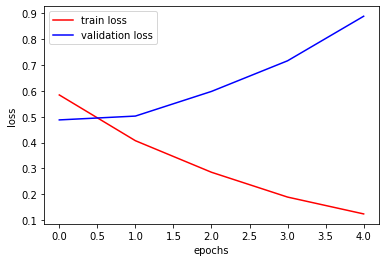

In [ ]:
train_losses = [ep['Training Loss'] for ep in training_stats]
val_losses = [ep['Valid. Loss'] for ep in training_stats]
plt.plot(range(len(train_losses)), train_losses, color='red', label='train loss')
plt.plot(range(len(val_losses)), val_losses, color='blue', label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


# Sentiment Prediction

The tweets dataset imported below can be downloaded from this [link](https://www.kaggle.com/ramyavidiyala/twitter-tweets-data-for-sentiment-analysis?utm_medium=social&utm_campaign=kaggle-dataset-share&utm_source=twitter)

In [ ]:
df_tweets = pd.read_csv('Datasets/vaccination_tweets.csv')


In [ ]:
tweets= df_tweets['text']

**Pre Processing the tweets**

In [ ]:
input_ids = []
attention_masks = []

for sent in tweets:
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', sent)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    sent = re.sub("\'", "", tweet)
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset= TensorDataset(input_ids, attention_masks)

batch_size = 32

dataloader = DataLoader(
            dataset,  
            sampler = SequentialSampler(tweets),     #Sequential Sampling
            batch_size = batch_size 
        )

**Prediction**

In [ ]:
print('Predicting labels for {:,} vaccine tweets...'.format(len(input_ids)))

model.eval()

predictions = []

for batch in dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  
  logits=np.argmax(logits,axis=1)
  for i in range(len(logits)):
    predictions.append(logits[i])
    

print('    DONE.')

Predicting labels for 88,978 vaccine tweets...
    DONE.


In [ ]:
df_tweets['Sentiment'] = predictions
df_tweets=df_tweets.dropna()      #drops the null values

In [ ]:
df_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,1
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,1
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,0
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,1
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,1


We take only the coloumns which are useful for us

In [ ]:
tweets= df_tweets.drop(['user_name','user_description','user_created','user_followers','user_friends','user_favourites','source','is_retweet'],axis=1)

In [ ]:
tweets['Sentiment']=tweets['Sentiment'].map({0:'negative',1:'neutral',2:'positive'})

In [ ]:
set(tweets['Sentiment'].to_list())

{'negative', 'neutral', 'positive'}

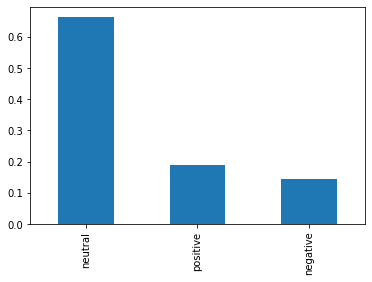

In [ ]:
tweets['Sentiment'].value_counts(normalize=True).plot.bar()

In [ ]:
def preprop(tweets):
  input_ids = []
  attention_masks = []

  for sent in tweets:
      
      url_pattern = re.compile(r'https?://\S+|www\.\S+')
      tweet = url_pattern.sub(r'', sent)
      tweet = re.sub('\S*@\S*\s?', '', tweet)
      tweet = re.sub('\s+', ' ', tweet)
      sent = re.sub("\'", "", tweet)
      
      encoded_dict = tokenizer.encode_plus(
                          sent,                      
                          add_special_tokens = True, 
                          max_length = 110,           
                          pad_to_max_length = True,
                          return_attention_mask = True,   
                          return_tensors = 'pt',     
                    )
      
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])


  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  return input_ids, attention_masks

In [ ]:
import json
real_data = []
f = open('Real_time_twitter_data/STREAM_long_en_2.json')
for line in f:
  text = json.loads(line)['text']
  # print(text)
  real_data.append(text)
input_ids, attention_masks = preprop(real_data)
real_dataset= TensorDataset(input_ids, attention_masks)

batch_size = 1000

real_dataloader = DataLoader(
            dataset,  
            sampler = SequentialSampler(vax_tweets),     #Sequential Sampling
            batch_size = batch_size 
        )
print('Predicting labels for {:,} vaccine tweets...'.format(len(input_ids)))



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 18,632 vaccine tweets...


In [ ]:
len(real_dataloader)

89

In [ ]:
from collections import Counter
import time
model.eval()

predictions = []
i=0
for batch in real_dataloader:
  if i==18:
    break
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  
  logits=list(np.argmax(logits,axis=1))
  # for i in range(len(logits)):
  logits_ = []
  for l in logits:
    if l==0:
      logits_.append('negative')
    elif l==1:
      logits_.append('neutral')
    else:
      logits_.append('postive')
  predictions+=(logits_)
  dict_ = dict(Counter(predictions))
  for key in dict_:
    dict_[key] = [dict_[key]]
  # print(dict_)
  pd.DataFrame(dict_).to_csv('real_time_bert_pred.csv')
  time.sleep(10)
    

print('    DONE.')

# Code for inferring on the real time data collected using tweepy

In [ ]:
from collections import Counter
import time
model.eval()

predictions = []
bert_times_recorded = []
negs = []
pos = []
neus = []
total_count = 0.0
i=0
initial_time = 0
for batch in real_dataloader:
  if i==18:
    break
  total_count+=batch[0].size(0)
  start_time = time.time()
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  end_time = time.time()
  initial_time+=(end_time-start_time)
  print(initial_time)
  bert_times_recorded.append(initial_time) 
  # print(bert_times_recorded) 
  logits=list(np.argmax(logits,axis=1))
  # for i in range(len(logits)):
  logits_ = []
  for l in logits:
    if l==0:
      logits_.append('negative')
    elif l==1:
      logits_.append('neutral')
    else:
      logits_.append('postive')
  predictions+=(logits_)
  dict_ = dict(Counter(predictions))
  negs.append(float(dict_['negative'])/total_count)
  pos.append(float(dict_['postive'])/total_count)
  neus.append(float(dict_['neutral'])/total_count)
  i+=1
  # for key in dict_:
  #   dict_[key] = [dict_[key]]
  # print(dict_)
  # pd.DataFrame(dict_).to_csv('real_time_bert_pred.csv')
  # time.sleep(10)
    

print('    DONE.')

6.699916839599609
13.398239374160767
20.186588525772095
26.967507123947144
33.81814122200012
40.74718189239502
47.752676248550415
54.82613229751587
61.9951913356781
69.24631524085999
76.39982962608337
83.61796927452087
90.90871238708496
98.2365288734436
105.64284944534302
113.07509684562683
120.56551718711853
128.0648431777954
    DONE.


# Bert estimation

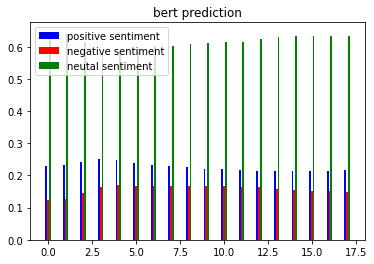

In [ ]:
plt.bar(np.arange(len(pos))-0.1, pos, color='blue', width= 0.1,label = 'positive sentiment')
plt.bar(np.arange(len(negs)), negs, color='red', width=0.1, label = 'negative sentiment')
plt.bar(np.arange(len(neus))+0.1, neus, color='green', width= 0.1, label = 'neutal sentiment')
plt.legend()
plt.title('bert prediction')
plt.show()

# BERT latency

In [ ]:
import pandas as pd
pd.DataFrame({'time':bert_times_recorded}).to_csv("bert_time.csv", index=False)

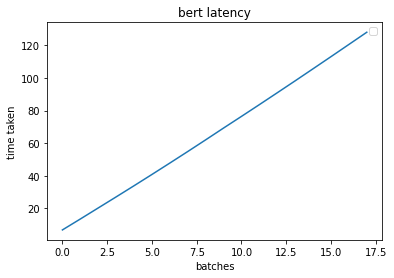

In [ ]:
plt.plot(np.arange(len(bert_times_recorded)), bert_times_recorded)
plt.xlabel("batches")
plt.ylabel("time taken")
plt.title("bert latency")
plt.legend()
plt.show()

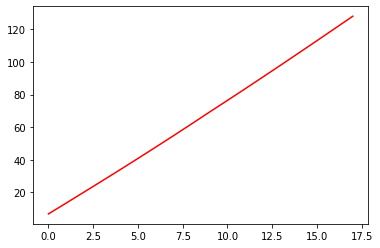

In [ ]:
plt.plot(np.arange(len(bert_times_recorded)), bert_times_recorded, color='red')
plt.show()
pd.DataFrame({'time':bert_times_recorded}).to_csv("bert_latency.csv", index=False)

# Model Saving

In [ ]:
torch.save(model.state_dict(), "Trained_models/model.pt")